# Segmentation 

This notebook shows how to use Cellpose (generalist algorithm for cellular segmentation) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Segment an initial image to test Cellpose parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [30]:
from octopuslite import DaskOctopusLiteLoader
from cellpose import models, io, plot
from tqdm import tqdm

## 1. Load images

In [65]:
# define experiment ID and select a position
expt = 'MK0003'
pos = 'Pos1'
image_path = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}/{pos}_aligned'
images = DaskOctopusLiteLoader(image_path)

Using cropping: None


## 2. Set Cellpose parameters for test run

In [40]:
# set channels to run on
segmentation_channel = 'rfp'
# define channels for cellpose, grayscale=0, R=1, G=2, B=3, channels = [cytoplasm, nucleus]
channels = [0,0]
# pick image to run test segmentation on 
test_image_index = 100
# set diameter of segments for cellpose, if set to None then size of cells estimated per image
diameter = None 
# Define cellpose model_type='cyto' or model_type='nuclei'
model_type='cyto'

### 2.1 Test run and display initial results

2021-11-09 12:03:56,599 [INFO] >>>> using CPU
2021-11-09 12:03:56,659 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2021-11-09 12:04:20,453 [INFO] estimated cell diameter(s) in 23.79 sec
2021-11-09 12:04:20,454 [INFO] >>> diameter(s) = 
2021-11-09 12:04:20,455 [INFO] [ 34.63 ]
2021-11-09 12:04:20,455 [INFO] ~~~ FINDING MASKS ~~~
2021-11-09 12:04:46,098 [INFO] >>>> TOTAL TIME 49.44 sec


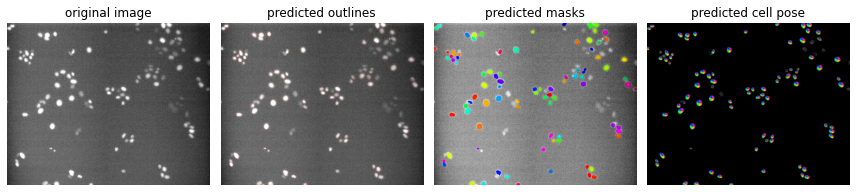

In [47]:
## define model type
model = models.Cellpose(gpu=False, model_type = model_type)
## run cellpose on test image
img = io.imread(images.files(segmentation_channel)[test_image_index])
masks, flows, styles, diams = model.eval(img, diameter = diameter, channels = channels)
## display results
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0,0])
plt.tight_layout()
plt.show()

## 3. Batch segment a whole stack of images

In [ ]:
### iterate over many expt and positions (optional)
for expt, pos in zip(['MK0003', 'MK0001'], ['Pos0', 'Pos1']):
    print('Starting experiment position:', expt, pos)
    
    # load images
    image_path = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'cellpose_masks')):
        os.mkdir(image_path.replace('_aligned', '_cellpose_masks'))

    # set multi-channel or single channel segmentation
    for segmentation_channel in ['gfp', 'rfp']:
        # find files corresponding to segmentation channel
        files = images.files(segmentation_channel)
        for filename in tqdm(files):
            # load image
            img = io.imread(filename)
            # run segmentation
            masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels)
            # save results as png in cellpose directory
            io.save_to_png(img, masks, flows, filename.replace('aligned', 'cellpose_masks'))